# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Understanding Data
For each subset:
- understand how the data is projected
- size of data
- the type of variables
- any missing or invalid values

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
portfolio.id.nunique()

10

**Note:**
10 unique offers, 4 discount, 4 bogo, and 2 informational

In [7]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [8]:
'''
offer_type_dummies = pd.get_dummies(portfolio['offer_type'])
portfolio=pd.concat([portfolio, offer_type_dummies], axis=1)
portfolio.drop('offer_type', axis=1, inplace=True)
portfolio.head()
'''

,channels,difficulty,duration,id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [9]:
'''
channels_list=[]
for index, row in portfolio.iterrows():
    chs = row['channels']
    for c in chs:
        if c not in channels_list:
            channels_list.append(c)
channels_list
'''

['email', 'mobile', 'social', 'web']

In [10]:
'''
portfolio = pd.concat([portfolio,pd.DataFrame(columns = channels_list)], axis=1)
portfolio.head()
'''

,offer_id,difficulty,duration,reward,channels,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,"[email, mobile, social]",1,0,0,NaN,NaN,NaN,NaN
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,"[web, email, mobile, social]",1,0,0,NaN,NaN,NaN,NaN
2,3f207df678b143eea3cee63160fa8bed,0,4,0,"[web, email, mobile]",0,0,1,NaN,NaN,NaN,NaN
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,"[web, email, mobile]",1,0,0,NaN,NaN,NaN,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,"[web, email]",0,1,0,NaN,NaN,NaN,NaN


In [11]:
'''
for index, row in portfolio.iterrows():
    chs = row['channels']
    for c in chs:
        if c == 'email': portfolio['email'].loc[index] = 1
        elif c == 'mobile': portfolio['mobile'].loc[index] = 1
        elif c == 'social': portfolio['social'].loc[index] = 1
        else: portfolio['web'].loc[index] = 1

        #if pd.isnull(portfolio['email'].loc[index]): portfolio['email'].loc[index] = np.where(c == 'email', 1, 0)
        #elif pd.isnull(portfolio['mobile'].loc[index]): portfolio['mobile'].loc[index] = np.where(c == 'mobile', 1, 0)
        #elif pd.isnull(portfolio['social'].loc[index]): portfolio['social'].loc[index] = np.where(c == 'social', 1, 0)
        #elif pd.isnull(portfolio['web'].loc[index]): portfolio['web'].loc[index] = np.where(c == 'web', 1, 0)

portfolio= portfolio.fillna(value=0)
portfolio.drop('channels', axis=1, inplace=True)
portfolio.head()
'''

/Users/FarahMF/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,offer_id,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [12]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

**Note:**
Oops, we have missing data. In addition, other than the 'O' gender, referring to other, we have 2175 customers with no gender info.

In [13]:
profile[profile['gender'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [14]:
profile[profile['gender'].isnull()].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

**Note:** seems like the customers with missing gender value are the same customers missing income values

In [15]:
profile[profile['gender'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


**Note:** 
notice the age. 118 years?

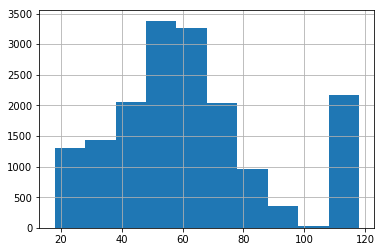

In [16]:
profile.age.hist()

In [17]:
profile[profile['age']<118].sort_values(['age'], ascending=False).head()

,age,became_member_on,gender,id,income
4100,101,20150526,F,d2fdc2be8ab64e4ba04830d441e53fd5,99000.0
1556,101,20171004,F,4d2ccfcbbebf4bd9baf4b7e433d0e288,43000.0
15800,101,20170309,F,047ad0135cfe4c0ea5ba019da4de9c52,59000.0
14846,101,20171109,F,e0ea90ddd2f147e082d21e97f51ec1b1,56000.0
16864,101,20171127,F,1593d617fac246ef8e50dbb0ffd77f5f,82000.0


In [18]:
profile[profile['age']<102].isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

**Note:**
customers with missing gender and income values are with age 118 years

In [26]:
'''
gender_dummies = pd.get_dummies(profile['gender'])
profile=pd.concat([profile, gender_dummies], axis=1)
profile.drop('gender', axis=1, inplace=True)
profile.head()
'''

,user_id,became_member_on,age,income,F,M,O
0,0610b486422d4921ae7d2bf64640c50b,20170715,55,112000.0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,20170509,75,100000.0,1,0,0
2,e2127556f4f64592b11af22de27a7932,20180426,68,70000.0,0,1,0
3,389bc3fa690240e798340f5a15918d5c,20180209,65,53000.0,0,1,0
4,2eeac8d8feae4a8cad5a6af0499a211d,20171111,58,51000.0,0,1,0


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.shape

(306534, 4)

In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Do we have the information for all the customers? and did all our customers purchased at least once?**

In [24]:
transcript.person.nunique() == profile.id.nunique()

True

In [25]:
def missing_ids(x,y):
    '''
    INPUT:
    x - (pandas dataframe) dataframe of transript or profile
    y - (pandas dataframe) dataframe of transript or profile
    
    OUTPUT:
    missing_ids - (list) a list of ids that exist in x dataframe but not in y dataframe
    
    Description:
    
    Computes the ids that exist in x dataframe but not in y dataframe.
    '''
    missing_ids=[]
    for i in x:
        if i not in y:
            missing_ids.append(i)
    return missing_ids

In [26]:
def is_missing_data(transcript,profile):
    '''
    INPUT:
    transcript - (pandas dataframe) records for transactions, offers received, offers viewed, and offers completed
    profile - (pandas dataframe) demographic data for each customer
    
    OUTPUT:
    len(missing_info), len(missing_tran) - length of lists 
    
    Description:
    Return the length of the list of customers who we don't have profile info, and the list of customers who don't have any transcripts
    '''
    transcript_ids = transcript.person.unique()
    profile_ids = profile.id.unique()

    #customers who we don't have profile info
    missing_info=missing_ids(transcript_ids,profile_ids)

    #customers who don't have any transcripts
    missing_tran=missing_ids(profile_ids,transcript_ids)
    
    return len(missing_info), len(missing_tran)

In [27]:
is_missing_data(transcript, profile)

(0, 0)

**Note:**
we have the data of all customers, and all customers purchased at least once

# Cleaning Data
## portfolio:
- rename 'id' to 'offer_id'
- reorder columns for better reading

## profile
- rename 'id' to 'user_id'
- reorder columns for better reading
- convert 'became_member_on' to datetime
- drop missing values: customers with age 118
- calculate a new column 'member_duration' that calculates the membership duration in days

## transcript
- rename 'person' to 'user_id'
- reorder columns for better reading
- remove the date of the customers we dropped from 'profile' dataset
- extract 'offer_id' and 'amount' values from 'value' column, then drop 'value' column


In [28]:
#rename 'id' to 'offer_id'
portfolio=portfolio.rename(columns={'id': 'offer_id'})
#reorder columns for better reading
titles = ['offer_id', 'offer_type', 'difficulty', 'duration', 'reward', 'channels']
portfolio = portfolio.reindex(columns=titles)
portfolio.head()

,offer_id,offer_type,difficulty,duration,reward,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,"[web, email]"


In [29]:
#rename 'id' to 'user_id'
profile=profile.rename(columns={'id': 'user_id'})
#reorder columns for better reading
titles = ['user_id', 'became_member_on', 'age', 'gender', 'income']
profile = profile.reindex(columns=titles)
profile.head()

,user_id,became_member_on,age,gender,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,118,None,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,55,F,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,118,None,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,75,F,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,118,None,NaN


In [30]:
#convert 'became_member_on' to datetime
#20170715
profile.became_member_on =pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,user_id,became_member_on,age,gender,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,118,None,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,55,F,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,118,None,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,75,F,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,118,None,NaN


In [31]:
#calculate a new column 'member_duration' that calculates the membership duration in days
profile['member_duration']=(pd.to_datetime('today')-profile['became_member_on']).astype('timedelta64[D]')
profile.head()

,user_id,became_member_on,age,gender,income,member_duration
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,118,None,NaN,930.0
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,55,F,112000.0,777.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,118,None,NaN,415.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,75,F,100000.0,844.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,118,None,NaN,757.0


In [32]:
#drop missing values: customers with age 118
profile=profile[profile['age']<=101].reset_index(drop=True)
profile.head()

,user_id,became_member_on,age,gender,income,member_duration
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,55,F,112000.0,777.0
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,75,F,100000.0,844.0
2,e2127556f4f64592b11af22de27a7932,2018-04-26,68,M,70000.0,492.0
3,389bc3fa690240e798340f5a15918d5c,2018-02-09,65,M,53000.0,568.0
4,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,58,M,51000.0,658.0


In [33]:
profile.isnull().sum() #all should be zeros

user_id             0
became_member_on    0
age                 0
gender              0
income              0
member_duration     0
dtype: int64

In [34]:
#rename 'person' to 'user_id'
transcript=transcript.rename(columns={'person': 'user_id'})
#reorder columns for better reading
titles = ['user_id', 'event', 'time', 'value']
transcript = transcript.reindex(columns=titles)
transcript.head()

,user_id,event,time,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,e2127556f4f64592b11af22de27a7932,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
#remove the date of the customers we dropped from 'profile' dataset
transcript = pd.merge(transcript, profile[['user_id']], on='user_id')
transcript.head()

,user_id,event,time,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89}
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78}


In [36]:
transcript[transcript['event']=='transaction'].head()

,user_id,event,time,value
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89}
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78}
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,{'amount': 19.67}
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,{'amount': 29.72}
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,{'amount': 23.93}


In [37]:
transcript[transcript['event']=='offer received'].head()

,user_id,event,time,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
10,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
18,e2127556f4f64592b11af22de27a7932,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


In [38]:
transcript[transcript['event']=='offer viewed'].head()

,user_id,event,time,value
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
11,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
17,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
19,e2127556f4f64592b11af22de27a7932,offer viewed,18,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


In [39]:
transcript[transcript['event']=='offer completed'].head()

,user_id,event,time,value
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
14,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
15,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
28,e2127556f4f64592b11af22de27a7932,offer completed,522,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
29,e2127556f4f64592b11af22de27a7932,offer completed,522,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...


In [40]:
transcript = pd.concat([transcript,pd.DataFrame(columns = ['offer_id','amount'])], axis=1)
transcript.head()

,user_id,event,time,value,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89},NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78},NaN,NaN


In [42]:
'''
transcript = pd.read_csv('transcript_saved.csv')
#transcript.drop('Unnamed: 0', axis=1, inplace=True)
transcript.head()
'''

,user_id,event,time,value,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89},NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78},NaN,17.78


In [45]:
#extract 'offer_id' and 'amount' values from 'value' column, then drop 'value' column

for index, row in transcript.iterrows():
    l=transcript.shape[0]
    #perc=(index/l)*100
    #perc_int=int(perc)
    if((index%10000)==0):
        print(index)
        print(pd.to_datetime('now'))
    if row['event'] != 'transaction': 
        if row['event'] == 'offer completed':
            transcript['offer_id'].loc[index] = row['value'].get('offer_id')
        else:
            transcript['offer_id'].loc[index] = row['value'].get('offer id')
    else:
        transcript['amount'].loc[index] = row['value'].get('amount')

0
2019-08-29 09:51:19.613275


/Users/FarahMF/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


10000
2019-08-29 09:58:59.703355
20000
2019-08-29 10:06:40.339209
30000
2019-08-29 10:14:32.470876
40000
2019-08-29 10:22:21.540606
50000
2019-08-29 10:30:29.895528
60000
2019-08-29 10:38:39.190662
70000
2019-08-29 10:46:47.903282
80000
2019-08-29 10:55:44.083258
90000
2019-08-29 11:04:16.403303
100000
2019-08-29 11:12:47.481166
110000
2019-08-29 11:21:16.247422
120000
2019-08-29 11:30:02.391072
130000
2019-08-29 11:38:38.820403
140000
2019-08-29 11:47:14.076752
150000
2019-08-29 11:55:56.760808
160000
2019-08-29 12:05:01.610195
170000
2019-08-29 12:14:26.940465
180000
2019-08-29 12:23:35.058836
190000
2019-08-29 12:33:23.112286
200000
2019-08-29 12:42:35.861859
210000
2019-08-29 12:52:15.580845
220000
2019-08-29 13:01:40.859307
230000
2019-08-29 13:11:53.332730
240000
2019-08-29 13:20:59.388797
250000
2019-08-29 13:30:21.139497
260000
2019-08-29 13:39:47.959582
270000
2019-08-29 13:49:24.044233


In [46]:
transcript.head()

,user_id,event,time,value,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89},NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78},NaN,17.78


In [47]:
transcript.drop('value', axis=1, inplace=True)
transcript.head()

,user_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78


In [49]:
#transcript.to_csv('transcript_saved.csv')

In [51]:
'''
results = pd.read_csv('transcript_saved.csv')
results.head()
'''

,Unnamed: 0,user_id,event,time,value,offer_id,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,{'amount': 19.89},NaN,19.89
3,3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
4,4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,{'amount': 17.78},NaN,17.78


# Analysis
## Customers:
- Who are the customers that purchase with offers only?
- who are the customers that fulfill offer conditions without using offers?

## Offers:
- Which offers are most popular to offers only customers?
- Which offers are less fulfilled by non offer users?

#### Notes:
- typical event order: 'offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed', however it's not a rule of thumb. users might not receive an offer and complete an offer, users might receive the offer or view an offer after fulfilling the offer (completed) which means they didn't benefit from the offer, the user might have more than one transaction to fulfill the offer

#### Assumptions:
- if 'offer viewed' then 'offer received' occurred
- if 'offer completed' they 'transaction' occurred

#### Definitions:
- offer users: the customers that used offers after reviewing them
- nonoffer users: the customers that fulfilled offers without receiving or viewing an offer

## Analysis 1: split data to:
- viewed_completed: the customers that completed offers AFTER reviewing
- viewed_notcompleted: the customers that received offers and viewed them but DIDN'T completed them
- completed_notviewed: the customers that completed offers WITHOUT viewing
- completed_notreceived: the customers that completed offers WITHOUT receiving

In [48]:
transcript=transcript.sort_values(['user_id','time'])
transcript.head()

,user_id,event,time,offer_id,amount
252233,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN
252234,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN
252235,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16
252236,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN
252237,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN


In [56]:
'''
#convert time in hours to time in days
transcript['time_in_days']=(transcript['time']*0.041667).astype(int)
transcript.head()
'''

,user_id,event,time,offer_id,amount,time_in_days
252233,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,7
252234,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,8
252235,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,9
252236,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,14
252237,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,15


In [49]:
def merge_x_y(x,y,c,o,h):
    '''
    INPUT:
    x - (pandas dataframe) to merge with
    y - (pandas dataframe) to merge with
    c - (list of strings) columns
    o - (list of strings) column names to join on
    h - (string) type of merge to be performed
    
    OUTPUT:
    merged_df - merged dataframe 
    
    Description:
    Return a new dataframe that merge two dataframes based on the passed parameters
    '''
    merged_df = pd.merge(x, y[c], on=o, how=h , indicator=True)
    if h != 'inner':
        merged_df=(merged_df.query('_merge == "'+h+'_only"').drop('_merge', 1))
    return merged_df


In [50]:
#all the uses that completed offers
offers_completed=transcript[['user_id','offer_id','event','time']][(transcript['event']=='offer completed')].groupby(['user_id','offer_id'])
offers_completed=offers_completed.apply(pd.DataFrame)
offers_completed.head()


,user_id,offer_id,event,time
252240,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,414
252244,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer completed,528
252249,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer completed,576
51187,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,252
51195,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,576


In [51]:
offers_completed.shape

(32444, 4)

In [52]:
#all the uses that viewed offers
offers_viewed=transcript[['user_id','offer_id','event','time']][(transcript['event']=='offer viewed')].groupby(['user_id','offer_id'])
offers_viewed=offers_viewed.apply(pd.DataFrame)
offers_viewed.head()


,user_id,offer_id,event,time
252234,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192
252237,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372
252241,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456
252245,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,540
51182,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,offer viewed,6


In [53]:
offers_viewed.shape

(49860, 4)

In [54]:
#all the uses that received offers
offers_received=transcript[['user_id','offer_id','event','time']][(transcript['event']=='offer received')].groupby(['user_id','offer_id'])
offers_received=offers_received.apply(pd.DataFrame)
offers_received.head()


,user_id,offer_id,event,time
252233,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168
252236,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336
252238,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408
252242,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer received,504
252247,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,576


In [55]:
offers_received.shape

(66501, 4)

In [56]:
#the customers that completed offers AFTER reviewing
viewed_completed=merge_x_y(offers_viewed,offers_completed,['user_id','offer_id','event','time'],['user_id','offer_id'],'inner')
viewed_completed=viewed_completed[viewed_completed['time_x']<viewed_completed['time_y']]
viewed_completed.head()


,user_id,offer_id,event_x,time_x,event_y,time_y,_merge
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,186,offer completed,252,both
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,432,offer completed,576,both
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,516,offer completed,576,both
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,12,offer completed,54,both
6,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,12,offer completed,510,both


In [57]:
#the customers that received offers and viewed them but DIDN'T completed offers
viewed_notcompleted=merge_x_y(offers_viewed,offers_completed,['user_id','offer_id','event','time'],['user_id','offer_id'],'left')
viewed_notcompleted.head()


,user_id,offer_id,event_x,time_x,event_y,time_y
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,offer viewed,6,NaN,NaN
6,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,offer viewed,354,NaN,NaN
12,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,offer viewed,660,NaN,NaN


In [58]:
#the customers that completed offers WITHOUT viewing
completed_notviewed=merge_x_y(offers_viewed,offers_completed,['user_id','offer_id','event','time'],['user_id','offer_id'],'right')
completed_notviewed.head()


,user_id,offer_id,event_x,time_x,event_y,time_y
36560,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,offer completed,576
36561,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,offer completed,696
36562,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,offer completed,336
36563,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,offer completed,582
36564,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,offer completed,414


In [59]:
#the customers that completed offers WITHOUT receiving
completed_notrecieved=merge_x_y(offers_received,offers_completed,['user_id','offer_id','event','time'],['user_id','offer_id'],'right')
completed_notrecieved.head()


,user_id,offer_id,event_x,time_x,event_y,time_y


**Note:**
seems like we don't have customers that fulfilled offers without receiving offers, but they didn't review the offers

## Analysis 2: split the data of the completed offers more to:
- offer_only_users_id: ids of the users that only buy with offers
- no_offer_only_users_id: #ids of users that never used/benefited from offers

In [60]:
#ids of the users that complete offers without viewing offer
no_offer_users_id=completed_notviewed['user_id'].drop_duplicates()
no_offer_users_id=pd.DataFrame(no_offer_users_id)

#ids of the users that complete offers after viewing offer
offer_users_id=viewed_completed['user_id'].drop_duplicates()
offer_users_id=pd.DataFrame(offer_users_id)

In [61]:
#ids of the users that only buy with offers
offer_only_users_id=merge_x_y(offer_users_id,no_offer_users_id,['user_id'],['user_id'],'left')
offer_only_users_id.head()


,user_id
0,0011e0d4e6b944f998e987f904e8c1e5
1,0020c2b971eb4e9188eac86d93036a77
2,0020ccbbb6d84e358d3414a3ff76cffd
4,00426fe3ffde4c6b9cb9ad6d077a13ea
5,004b041fbfe44859945daa2c7f79ee64


In [62]:
#ids of users that never used/benefited from offers
no_offer_only_users_id=merge_x_y(offer_users_id,no_offer_users_id,['user_id'],['user_id'],'right')
no_offer_only_users_id.head()


,user_id
2903,0009655768c64bdeb2e877511632db8f
2904,005500a7188546ff8a767329a2f7c76a
2905,00cf471ed1aa42a8bdde5561d67da2b1
2906,01176ee7289b48e39ee6261d5c071a07
2907,0121fe001b7a404fa9cbe486f8944baf


In [63]:
results=merge_x_y(offer_only_users_id,no_offer_only_users_id,['user_id'],['user_id'],'inner')
results.head() #should be empty

,user_id,_merge


## Analysis 3: get user demographics and offers information to answer questions:

In [64]:
def get_users_info(df):
    offer_users = pd.merge(profile, df[['user_id']], on=['user_id'])
    offer_users = offer_users.drop_duplicates()
    return offer_users

def get_offers_info(df):
    used_offers = pd.merge(portfolio, df[['offer_id']], on=['offer_id'])
    #offer_users = offer_users.drop_duplicates()
    return used_offers

In [65]:
#the demographics of the users that only buy with offers
offer_only_users_info=get_users_info(offer_only_users_id)
offer_only_users_info.head()

,user_id,became_member_on,age,gender,income,member_duration
0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,75,F,100000.0,844.0
1,e2127556f4f64592b11af22de27a7932,2018-04-26,68,M,70000.0,492.0
2,389bc3fa690240e798340f5a15918d5c,2018-02-09,65,M,53000.0,568.0
3,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,58,M,51000.0,658.0
4,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,61,F,57000.0,719.0


In [66]:
#the demographics of the users that never used/benefited from offers
no_offer_only_users_info=get_users_info(no_offer_only_users_id)
no_offer_only_users_info.head()

,user_id,became_member_on,age,gender,income,member_duration
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,55,F,112000.0,777.0
1,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,26,M,46000.0,2025.0
2,d1ede868e29245ea91818a903fec04c6,2017-09-16,53,O,52000.0,714.0
3,8e7c7465e98c43d8a01f51e2b5c29542,2013-09-18,69,F,37000.0,2173.0
4,e9844d5beac04bf8b8d3ad18f7e37fca,2017-06-26,56,F,52000.0,796.0


## Analysis 4: answer questions:

### Customers:
- Who are the customers that purchase with offers only?
- who are the customers that fulfill offer conditions without using offers?

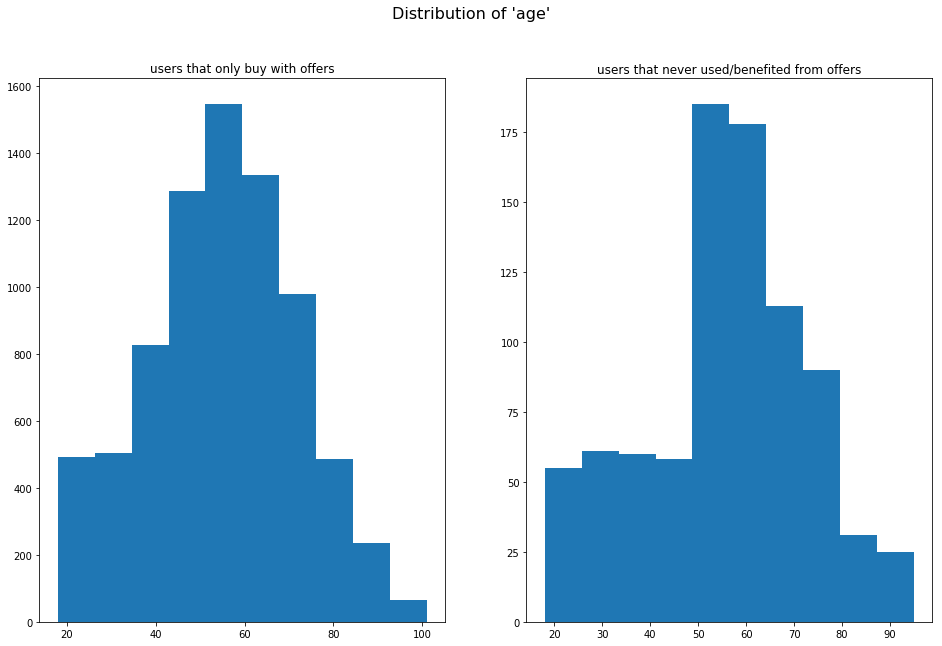

In [71]:
# Compare the distribution of 'age'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
fig.suptitle("Distribution of 'age'", fontsize=16)

axs[0].hist(offer_only_users_info['age'])
axs[0].set_title('users that only buy with offers')
axs[1].hist(no_offer_only_users_info['age'])
axs[1].set_title('users that never used/benefited from offers');


**Notes:**
- customers between 40-50 years tend to buy with offers more
- customers between 70-80, and 90+ years tend to buy without offers

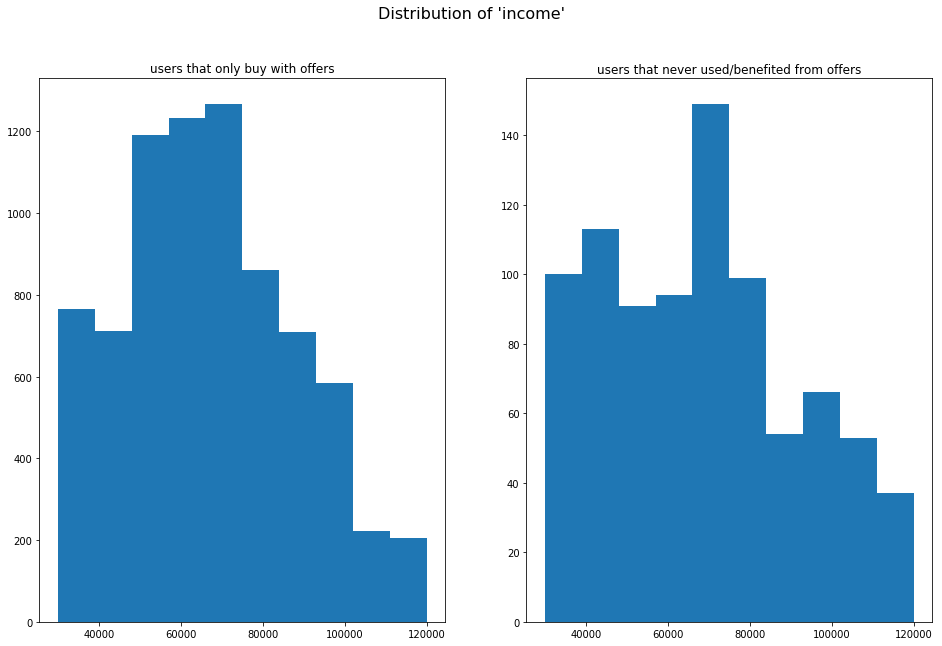

In [72]:
# Compare the distribution of 'income'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
fig.suptitle("Distribution of 'income'", fontsize=16)

axs[0].hist(offer_only_users_info['income'])
axs[0].set_title('users that only buy with offers')
axs[1].hist(no_offer_only_users_info['income'])
axs[1].set_title('users that never used/benefited from offers');

**Notes:**
- customers with less income (between 5000-7000) tend to buy with offers more
- in general, the higher the income, the less the customers buy

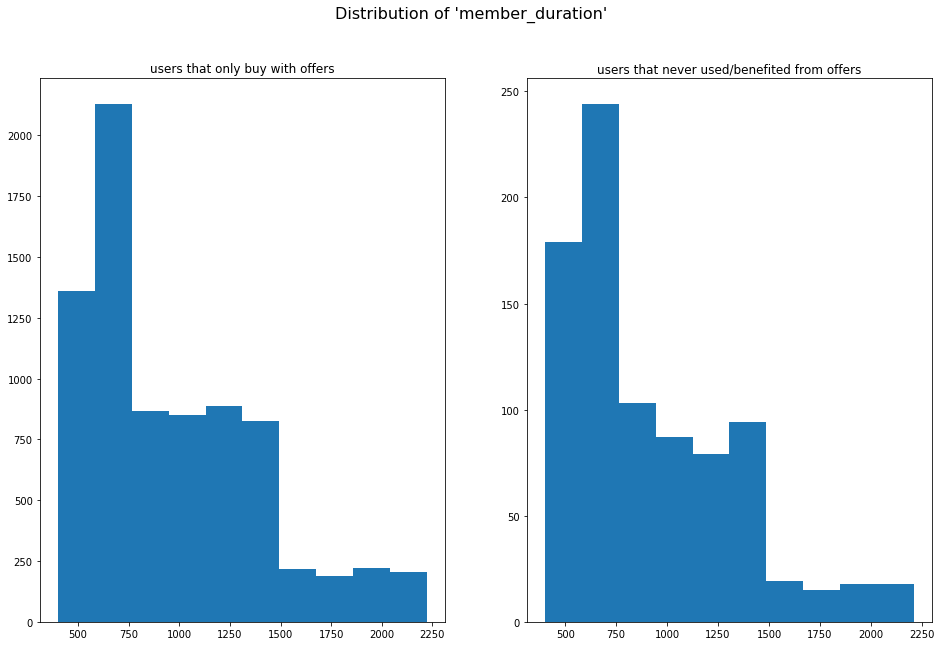

In [73]:
# Compare the distribution of 'member_duration'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
fig.suptitle("Distribution of 'member_duration'", fontsize=16)

axs[0].hist(offer_only_users_info['member_duration'])
axs[0].set_title('users that only buy with offers')
axs[1].hist(no_offer_only_users_info['member_duration'])
axs[1].set_title('users that never used/benefited from offers');

**Note:**
there isn't much difference

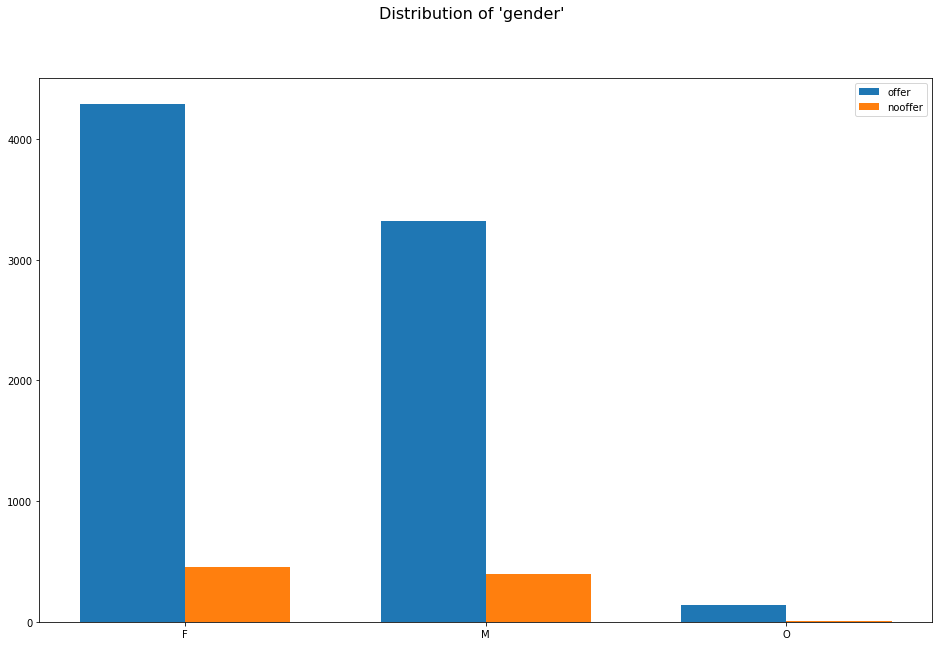

In [75]:
# Compare the distribution of 'gender'
labels = no_offer_only_users_info.gender.unique().tolist()
p1 = offer_only_users_info.gender.value_counts().tolist()
p2 = no_offer_only_users_info.gender.value_counts().tolist()

x = np.arange(len(labels))  
width = 0.35  
          
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle("Distribution of 'gender'", fontsize=16)
r1 = ax.bar(x - width/2, p1, width, label='offer')
r2 = ax.bar(x + width/2, p2, width, label='nooffer')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

**Notes:**
- there isn't much difference
- in general, females tend to buy more

### Offers:
- Which offers are most popular to offers only customers?
- Which offers are less fulfilled by non offer users?

In [89]:
#ids of the offers that were completed by users WITHOUT being viewed
no_view_offer_ids=completed_notviewed['offer_id'].drop_duplicates()
no_view_offer_ids=pd.DataFrame(no_view_offer_ids)

#ids of the offers that were completed by users AFTER viewed
view_offer_ids=viewed_completed['offer_id'].drop_duplicates()
view_offer_ids=pd.DataFrame(view_offer_ids)


In [90]:
#offers that is being used, or not being used only by one group of users
results=merge_x_y(no_view_offer_ids, view_offer_ids,['offer_id'], 'offer_id', 'right')
results.head()

,offer_id


In [91]:
#offers that is being used, or not being used only by one group of users
results=merge_x_y(no_view_offer_ids, view_offer_ids,['offer_id'], ['offer_id'], 'left')
results.head()

,offer_id


In [92]:
results=merge_x_y(portfolio, view_offer_ids,['offer_id'], ['offer_id'], 'left')
results.head()

,offer_id,offer_type,difficulty,duration,reward,channels
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,"[web, email, mobile]"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,0,"[email, mobile, social]"


**Note:**
All the discount and BOGO offers are being completed by both groups of users. meaning there isn't a specific offer that is used only by one group. therefore I'll look into how are the offered being used for each group.

In [93]:
completed_notviewed.offer_id.value_counts()

0b1e1539f2cc45b7b9fa7c272da2e1d7    1634
9b98b8c7a33c4b65b9aebfe6a799e6d9    1324
2906b810c7d4411798c6938adc9daaa5    1121
ae264e3637204a6fb9bb56bc8210ddfd     340
2298d6c36e964ae4a3e7e9706d1fb8c2     105
fafdcd668e3743c1bb461111dcafc2a4      94
f19421c1d4aa40978ebb69ca19b0e20d      81
4d5c57ea9a6940dd891ad53e9dbe8da0      60
Name: offer_id, dtype: int64

In [94]:
completed_notviewed.shape

(4759, 6)

**Note:**
We can notice the difference between the offers. the top three are fulfilled more than the rest, therefore we don't need to send them to the customers in this group. we might want to send the last three to encourage purchase.

In [95]:
viewed_completed.offer_id.value_counts()

fafdcd668e3743c1bb461111dcafc2a4    4878
2298d6c36e964ae4a3e7e9706d1fb8c2    4609
f19421c1d4aa40978ebb69ca19b0e20d    3643
4d5c57ea9a6940dd891ad53e9dbe8da0    3005
ae264e3637204a6fb9bb56bc8210ddfd    2907
2906b810c7d4411798c6938adc9daaa5    2344
9b98b8c7a33c4b65b9aebfe6a799e6d9    2280
0b1e1539f2cc45b7b9fa7c272da2e1d7    1533
Name: offer_id, dtype: int64

In [96]:
viewed_completed.shape

(25199, 7)

**Note:**
There isn't much difference between the completion of the offers as noticed in the other group, but we can notice the difference in the usage overall. receiving offers, in general, encourage purchase.

In [98]:
portfolio[portfolio['offer_id']=='fafdcd668e3743c1bb461111dcafc2a4']

,offer_id,offer_type,difficulty,duration,reward,channels
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,"[web, email, mobile, social]"


In [99]:
portfolio[portfolio['offer_id']=='2298d6c36e964ae4a3e7e9706d1fb8c2']

,offer_id,offer_type,difficulty,duration,reward,channels
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,"[web, email, mobile, social]"


In [97]:
portfolio[(portfolio['offer_id']=='fafdcd668e3743c1bb461111dcafc2a4')|(portfolio['offer_id']=='2298d6c36e964ae4a3e7e9706d1fb8c2')]


,offer_id,offer_type,difficulty,duration,reward,channels
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,"[web, email, mobile, social]"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,"[web, email, mobile, social]"


In [100]:
portfolio[portfolio['offer_id']=='9b98b8c7a33c4b65b9aebfe6a799e6d9']

,offer_id,offer_type,difficulty,duration,reward,channels
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,"[web, email, mobile]"


In [101]:
portfolio[portfolio['offer_id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7']

,offer_id,offer_type,difficulty,duration,reward,channels
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,"[web, email]"


In [102]:
portfolio[(portfolio['offer_id']=='9b98b8c7a33c4b65b9aebfe6a799e6d9')|(portfolio['offer_id']=='0b1e1539f2cc45b7b9fa7c272da2e1d7')]


,offer_id,offer_type,difficulty,duration,reward,channels
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,"[web, email]"


**Note:**
Looking into the top two offers and the last two offers, we can notice it that the discount offers sent via mobile channel are used more.

# Results:
## Customers:
- age and income have a minor impact on whether the customer relly on offers to purchase or not
- females buy coffee more than others

## Offers:
- all discount and BOGO offers are being fulfilled whether the customer relly on offers to purchase or not
- discount offers sent via mobile tend to be used more by the customer that relly on offers to purchase